In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tsplib95

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.

new code

In [ ]:
import numpy as np
import random
import time
import tsplib95
import pandas as pd

# Function to calculate tour distance
def tour_distance(tour, problem):
    dist = 0
    num_nodes = len(tour)
    for i in range(num_nodes):
        dist += problem.get_weight(tour[i], tour[(i + 1) % num_nodes])
    return dist

# Basic Cuckoo Search Algorithm
def basic_cuckoo_search(problem, runs=30, population_size=20, max_iterations=500, pa=0.25):
    num_nodes = problem.dimension
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration)
            new_population = []
            for tour in population:
                cuckoo = np.copy(tour)
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                new_population.append(cuckoo)

            # Replace worst solutions with new ones
            for i in range(population_size):
                if random.random() < pa:
                    population[i] = new_population[i]

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time

# Improved Cuckoo Search using Dynamic Cuckoo Search (DCS)
def dcs_cuckoo_search(problem, runs=30, population_size=20, max_iterations=500, initial_step_size=0.1, decay_rate=0.95, pc=0.25, pa=0.25):
    num_nodes = problem.dimension
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        # Initialize step sizes
        step_sizes = np.full(population_size, initial_step_size)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration) with dynamic step size
            new_population = []
            for i, tour in enumerate(population):
                cuckoo = np.copy(tour)
                # Calculate step size
                step_size = step_sizes[i]
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                # Update step size using dynamic cuckoo search
                if random.random() < step_size:
                    # Replace a randomly selected element by another randomly selected element
                    idx3, idx4 = np.random.choice(num_nodes, 2, replace=False)
                    cuckoo[idx3] = cuckoo[idx4]
                    step_size *= decay_rate
                new_population.append(cuckoo)
                step_sizes[i] = step_size

            # Replace worst solutions with new ones and apply intelligent cuckoos evolution
            for i in range(population_size):
                if random.random() < pa:  # Fraction (pa) of worse nests are abandoned and new ones are built
                    population[i] = new_population[i]
                if random.random() < pc:  # Intelligent cuckoos evolution with a fraction (pc)
                    j = random.randint(0, population_size - 1)
                    if fitness_values[i] > fitness_values[j]:
                        population[j] = new_population[i]

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time


In [ ]:
import os
import tsplib95
import numpy as np
import random
import time
import pandas as pd

# Function to get list of files in a folder
def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if file.endswith(".tsp"):  # Adjust file extension as needed
            files.append(os.path.join(folder_path, file))
    return files

# Function to run both algorithms for multiple files and create a dataframe
def run_algorithms_for_files(files):
    results = []
    for file_path in files:
        print(file_path)
        problem = tsplib95.load(file_path)
        num_nodes = problem.dimension

        # Run basic Cuckoo Search
        basic_stats = basic_cuckoo_search(problem, num_nodes)

        # Run Improved Cuckoo Search using Dynamic Cuckoo Search (DCS)
        improved_stats = dcs_cuckoo_search(problem, num_nodes)

        # Append results for this file
        results.append({
            'File': file_path.split('/')[-1].split('.')[0],
            'Basic Best Distance': basic_stats[0],
            'Basic Average Distance': basic_stats[1],
            'Basic Worst Distance': basic_stats[2],
            'Basic P_Dav(%)': basic_stats[3],
            'Basic P_Dbest(%)': basic_stats[4],
            'Basic Time (s)': basic_stats[5],
            'Improved Best Distance': improved_stats[0],
            'Improved Average Distance': improved_stats[1],
            'Improved Worst Distance': improved_stats[2],
            'Improved P_Dav(%)': improved_stats[3],
            'Improved P_Dbest(%)': improved_stats[4],
            'Improved Time (s)': improved_stats[5]
        })

    return pd.DataFrame(results)

# Function to calculate tour distance
def tour_distance(tour, problem):
    dist = 0
    num_nodes = len(tour)
    for i in range(num_nodes):
        dist += problem.get_weight(tour[i], tour[(i + 1) % num_nodes])
    return dist

# Basic Cuckoo Search Algorithm
def basic_cuckoo_search(problem, runs=30, population_size=20, max_iterations=20, pa=0.25):
    num_nodes = problem.dimension
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration)
            new_population = []
            for tour in population:
                cuckoo = np.copy(tour)
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                new_population.append(cuckoo)

            # Replace worst solutions with new ones
            for i in range(population_size):
                if random.random() < pa:
                    population[i] = new_population[i]

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time

# Improved Cuckoo Search using Dynamic Cuckoo Search (DCS)
def dcs_cuckoo_search(problem, runs=30, population_size=20, max_iterations=100, initial_step_size=0.1, decay_rate=0.95, pc=0.25, pa=0.25):
    num_nodes = problem.dimension
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        # Initialize step sizes
        step_sizes = np.full(population_size, initial_step_size)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration) with dynamic step size
            new_population = []
            for i, tour in enumerate(population):
                cuckoo = np.copy(tour)
                # Calculate step size
                step_size = step_sizes[i]
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                # Update step size using dynamic cuckoo search
                if random.random() < step_size:
                    # Replace a randomly selected element by another randomly selected element
                    idx3, idx4 = np.random.choice(num_nodes, 2, replace=False)
                    cuckoo[idx3] = cuckoo[idx4]
                    step_size *= decay_rate
                new_population.append(cuckoo)
                step_sizes[i] = step_size

            # Replace worst solutions with new ones and apply intelligent cuckoos evolution
            for i in range(population_size):
                if random.random() < pa:  # Fraction (pa) of worse nests are abandoned and new ones are built
                    population[i] = new_population[i]
                if random.random() < pc:  # Intelligent cuckoos evolution with a fraction (pc)
                    j = random.randint(0, population_size - 1)
                    if fitness_values[i] > fitness_values[j]:
                        population[j] = new_population[i]

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time


# Get list of files in the folder
folder_path = "/content/drive/MyDrive/tsp_problem"  # Specify your folder path here
files = get_files_in_folder(folder_path)

# Run algorithms for the file
print(files)
result_df = run_algorithms_for_files(files)

['/content/drive/MyDrive/tsp_problem/ch130.tsp', '/content/drive/MyDrive/tsp_problem/pr226.tsp', '/content/drive/MyDrive/tsp_problem/ch150.tsp', '/content/drive/MyDrive/tsp_problem/bayg29.tsp', '/content/drive/MyDrive/tsp_problem/a280.tsp', '/content/drive/MyDrive/tsp_problem/u159.tsp', '/content/drive/MyDrive/tsp_problem/gil262.tsp', '/content/drive/MyDrive/tsp_problem/kroA100.tsp', '/content/drive/MyDrive/tsp_problem/pr76.tsp', '/content/drive/MyDrive/tsp_problem/eil101.tsp', '/content/drive/MyDrive/tsp_problem/att48.tsp', '/content/drive/MyDrive/tsp_problem/kroB200.tsp', '/content/drive/MyDrive/tsp_problem/burma14.tsp', '/content/drive/MyDrive/tsp_problem/tsp225.tsp']
/content/drive/MyDrive/tsp_problem/ch130.tsp
/content/drive/MyDrive/tsp_problem/pr226.tsp
/content/drive/MyDrive/tsp_problem/ch150.tsp
/content/drive/MyDrive/tsp_problem/bayg29.tsp
/content/drive/MyDrive/tsp_problem/a280.tsp


In [ ]:
result_df

,File,Basic Best Distance,Basic Average Distance,Basic Worst Distance,Basic P_Dav(%),Basic P_Dbest(%),Basic Time (s),Improved Best Distance,Improved Average Distance,Improved Worst Distance,Improved P_Dav(%),Improved P_Dbest(%),Improved Time (s)
0,pr76,474207,525146.190,561426,10.741973,18.392601,13.286988,471085,521851.896,569082,10.776589,20.802403,7.825251
1,tsp225,36699,39090.064,40234,6.515338,9.632415,25.042488,36883,38906.909,40448,5.487376,9.665700,25.187943
2,pr226,1520298,1599868.224,1671367,5.233857,9.936802,25.555636,1512351,1592921.224,1655109,5.327482,9.439475,25.777801
3,u159,367506,418998.452,439208,14.011323,19.510430,17.985862,393437,418639.006,447629,6.405601,13.773997,17.320656
4,kroB200,290532,311767.587,324235,7.309208,11.600443,23.199076,291751,311627.337,326400,6.812774,11.876223,21.420991
5,kroA100,138469,155268.232,168882,12.132125,21.963761,11.897711,136948,154702.003,167236,12.964047,22.116424,12.139217
6,ch150,47051,50386.611,52587,7.089352,11.765956,16.646061,46252,50629.762,53050,9.465022,14.697743,17.050427
7,bayg29,3176,4093.991,4547,28.903999,43.167506,4.757695,3213,3923.587,4426,22.115998,37.752879,3.516208
8,burma14,4010,5356.166,6258,33.570224,56.059850,2.579071,3112,4602.448,5881,47.893573,88.978149,3.135235
9,ch130,39194,43305.669,45513,10.490557,16.122366,14.965269,40098,43093.057,45250,7.469343,12.848521,15.193325


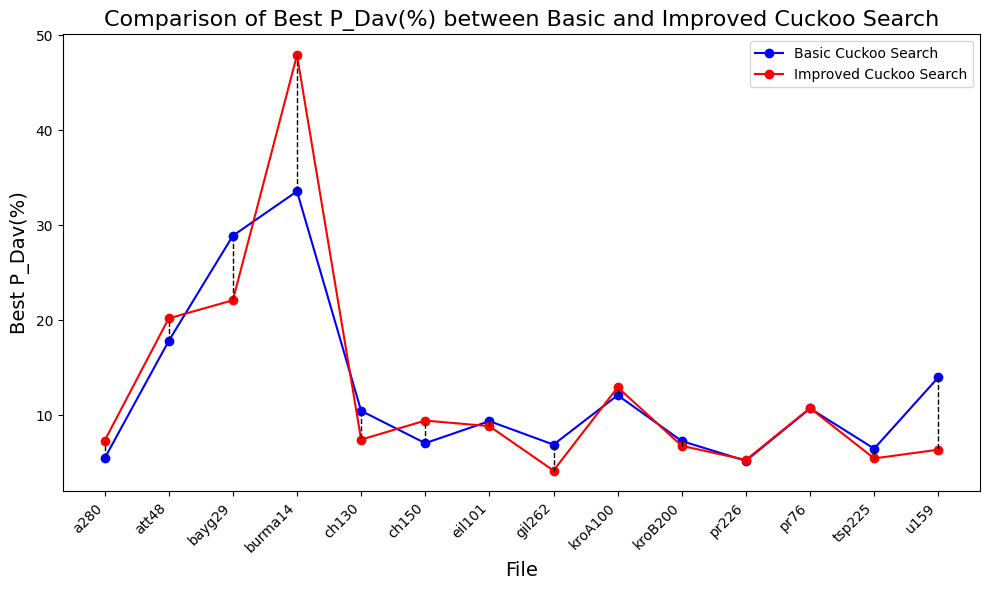

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extracting data for plotting
sorted_result_df = result_df.sort_values(by='File')  # Sorting the DataFrame

files = sorted_result_df['File']
basic_pdav_best = sorted_result_df['Basic P_Dav(%)']
improved_pdav_best = sorted_result_df['Improved P_Dav(%)']

# Plotting
plt.figure(figsize=(10, 6))

# Plotting basic Cuckoo Search
plt.plot(files, basic_pdav_best, marker='o', color='b', label='Basic Cuckoo Search', linestyle='-')

# Plotting improved Cuckoo Search
plt.plot(files, improved_pdav_best, marker='o', color='r', label='Improved Cuckoo Search', linestyle='-')

# Adding trendline between basic and improved
for i in range(len(files)):
    plt.plot([files[i], files[i]], [basic_pdav_best[i], improved_pdav_best[i]], color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('File', fontsize=14)
plt.ylabel('Best P_Dav(%)', fontsize=14)
plt.title('Comparison of Best P_Dav(%) between Basic and Improved Cuckoo Search', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Showing the plot
plt.tight_layout()
plt.show()